# An initial training pipeline

In [37]:
%load_ext dotenv
%dotenv ../src/.env
import sys
sys.path.append("../src")
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [38]:
returns = df[[ 'returns']].dropna()
returns.describe()

,returns
count,140617.000000
mean,0.036554
std,1.478978
min,0.000000
25%,0.003967
50%,0.009251
75%,0.018199
max,473.696419


In [39]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)

StandardScaler()

In [40]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=returns.columns)
scaled_returns.describe()

,returns
count,1.406170e+05
mean,-2.829700e-18
std,1.000004e+00
min,-2.471575e-02
25%,-2.203316e-02
50%,-1.846043e-02
75%,-1.241075e-02
max,3.202628e+02


###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='sector'>

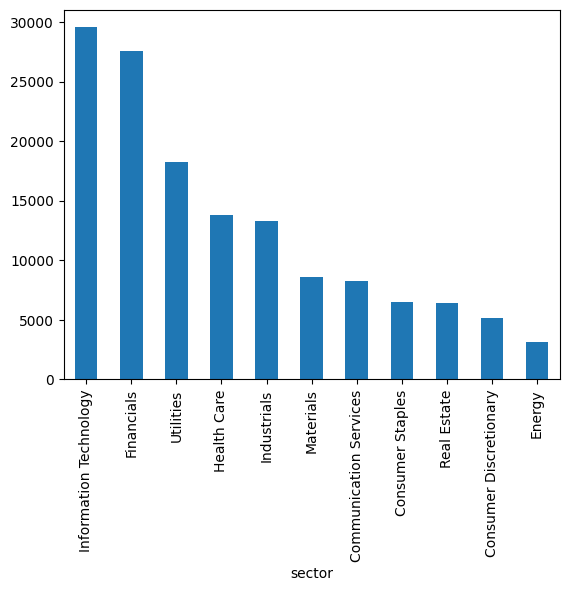

In [41]:
df['sector'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [42]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['sector']])

OneHotEncoder()

In [43]:
sector_enc = onehot.transform(df[['sector']])
sector_enc.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [45]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [46]:
X0 = df[['sector']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('knn',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3))])

In [47]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [48]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [49]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.5113562621674238,
 'accuracy_score_test': 0.5090669890484995,
 'cohen_kappa_train': 0.0181608622900985,
 'cohen_kappa_test': 0.01911710390013155,
 'log_loss_train': 0.6924042378311982,
 'log_loss_test': 0.6923450796184079,
 'f1_score_train': 0.6608714965235148,
 'f1_score_test': 0.6590443264600568}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [50]:
from sklearn.compose import ColumnTransformer

In [51]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['sector']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

In [52]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['sector']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.



![](./img/train_validate_test.png)


What scaling should we use>? equal length discretisation or equal length? to do this we have to test, so we use validation data set for this type of data. Overfitting is the enemy of generalization. Reserve some data as intermadiuate testing. 

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [53]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [54]:
# Schema
X = df[['returns', 'Volume', 'sector']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [55]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6879425866249176,
 'log_loss_test': 0.6877510754155509,
 'cohen_kappa_train': 0.04005061619496786,
 'cohen_kappa_test': 0.04125077540697408,
 'f1_score_train': 0.6126698461261586,
 'f1_score_test': 0.6082384509391544,
 'accuracy_score_train': 0.5217014467631176,
 'accuracy_score_test': 0.5198008800391128}

In [56]:
# Evaluate hyperparameter configuration 2
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6680424312491006,
 'log_loss_test': 1.1045123847720206,
 'cohen_kappa_train': 0.08665711627049122,
 'cohen_kappa_test': 0.024885322834316548,
 'f1_score_train': 0.5920836771826561,
 'f1_score_test': 0.5612085847887774,
 'accuracy_score_train': 0.5441140520479143,
 'accuracy_score_test': 0.5120227565669585}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.
+ Best performing is the lowes logloss. 
+ Only do if you have the computational capacity. 

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./img/grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [57]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [58]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,2.148997,0.134002,0.506934,0.544843,0.556469,0.614599,0.507319,0.534498,0.616164,0.722942,0.509209,0.571415,-1.417400,-0.667622,-0.262756,-0.239856
1,1.817006,0.164997,0.505369,0.544043,0.592017,0.615104,0.505180,0.533728,0.714903,0.725758,0.506053,0.569373,-1.316130,-0.667986,-0.261168,-0.240037
2,1.641999,0.123005,0.497351,0.542980,0.561484,0.616357,0.499503,0.532629,0.641026,0.731318,0.488243,0.569696,-1.104693,-0.665578,-0.261803,-0.239165
3,1.884004,0.164999,0.510436,0.541051,0.527879,0.606831,0.511633,0.532354,0.545191,0.705535,0.517451,0.568383,-3.336276,-0.668223,-0.291340,-0.240423
4,1.748995,0.115000,0.505103,0.544713,0.603656,0.645579,0.504762,0.529845,0.750744,0.826002,0.504724,0.571829,-1.668078,-0.665490,-0.266487,-0.239139


In [59]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,2.370355,0.300014,0.507111,0.544967,0.556331,0.614687,0.507474,0.534592,0.615597,0.723013,0.509802,0.571644,-1.441431,-0.667377,-0.262870,-0.239774
1,1.889033,0.134999,0.505298,0.544043,0.592126,0.615087,0.505127,0.533731,0.715328,0.725705,0.505946,0.569375,-1.317485,-0.668003,-0.261231,-0.240041
2,1.732077,0.130995,0.497386,0.542918,0.561256,0.616227,0.499530,0.532595,0.640388,0.731017,0.488307,0.569582,-1.111127,-0.665711,-0.262000,-0.239217
3,1.817656,0.132000,0.510685,0.541051,0.524154,0.606813,0.512060,0.532357,0.536832,0.705482,0.518445,0.568393,-3.205054,-0.668228,-0.288967,-0.240424
4,1.820999,0.138997,0.505138,0.544642,0.603312,0.645661,0.504794,0.529781,0.749610,0.826427,0.504994,0.571685,-1.641919,-0.665545,-0.266019,-0.239165


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [60]:
pd.DataFrame(d15_dict).mean()

fit_time                 1.926024
score_time               0.167401
test_accuracy            0.505124
train_accuracy           0.543524
test_f1                  0.567436
train_f1                 0.619695
test_precision           0.505797
train_precision          0.532611
test_recall              0.651551
train_recall             0.742329
test_roc_auc             0.505499
train_roc_auc            0.570136
test_neg_log_loss       -1.743403
train_neg_log_loss      -0.666973
test_neg_brier_score    -0.268217
train_neg_brier_score   -0.239724
dtype: float64